# Analyse des Données de Comptage Vélo à Paris

## Contexte du Test
L'objectif de cette étude est d'analyser les données de trafic cycliste de la ville de Paris pour comprendre les comportements de mobilité (Vélotaf vs Loisirs) et tenter de modéliser le volume de passage.

## 1. Préparation de l'environnement et Chargement des données
Nous utilisons les données OpenData de la ville de Paris. Le jeu de données contient des relevés horaires de compteurs vélos.
Nous commençons par charger les librairies nécessaires et le fichier CSV, en supprimant immédiatement les colonnes techniques (URLs, IDs photos) qui ne servent pas à l'analyse statistique.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration pour un affichage plus propre
pd.set_option('display.max_columns', None)

# 1. Chargement des données
# Note : Adaptation du séparateur (;) typique des fichiers OpenData français
path = r"C:\Users\wael\Downloads\test tecknique\analyse2\comptage-velo-donnees-compteurs.csv"
df = pd.read_csv(path, sep=';')

# 2. Nettoyage initial : Suppression des colonnes "bruit" (Photos, URLs, etc.)
cols_to_drop = [
    "Lien vers photo du site de comptage",
    "ID Photos",
    "test_lien_vers_photos_du_site_de_comptage_",
    "id_photo_1",
    "url_sites",
    "type_dimage"
]

# errors='ignore' permet d'éviter une erreur si la colonne n'existe pas
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Vérification des dimensions
print(f"Dimensions avant nettoyage : {df.shape}")
print(f"Dimensions après nettoyage : {df_clean.shape}")
print("\nColonnes conservées pour l'analyse :")
print(df_clean.columns.tolist())

Dimensions avant nettoyage : (954036, 16)
Dimensions après nettoyage : (954036, 10)

Colonnes conservées pour l'analyse :
['Identifiant du compteur', 'Nom du compteur', 'Identifiant du site de comptage', 'Nom du site de comptage', 'Comptage horaire', 'Date et heure de comptage', "Date d'installation du site de comptage", 'Coordonnées géographiques', 'Identifiant technique compteur', 'mois_annee_comptage']


## 2. Feature Engineering et Nettoyage Avancé
Les données brutes contiennent une date au format texte. Pour analyser les comportements (matin vs soir, semaine vs weekend), nous devons :
1.  Convertir la colonne date en format `datetime`.
2.  Extraire des variables temporelles clés : **Heure**, **Mois**, **Jour de la semaine**.
3.  Créer des indicateurs binaires pour faciliter les filtres ultérieurs :
    *   `est_weekend` : Pour distinguer le trafic pendulaire (travail) du trafic loisirs.
    *   `est_hiver` : Pour isoler l'impact potentiel de la météo (novembre à mars).

Enfin, nous renommons les colonnes pour les rendre plus manipulables dans le code.

In [2]:
# 1. Conversion de la date (de texte vers format Date compréhensible par Python)
df_clean['Date et heure de comptage'] = pd.to_datetime(df_clean['Date et heure de comptage'], utc=True)

# 2. Création des colonnes temporelles (Feature Engineering)
df_clean['heure'] = df_clean['Date et heure de comptage'].dt.hour
df_clean['mois'] = df_clean['Date et heure de comptage'].dt.month
df_clean['jour_semaine'] = df_clean['Date et heure de comptage'].dt.dayofweek # 0=Lundi, 6=Dimanche

# 3. Création des indicateurs pour l'analyse (Vélotaf vs Loisirs)
df_clean['est_weekend'] = df_clean['jour_semaine'] >= 5
# Hiver élargi (Nov-Mars) pour capter les périodes froides/pluvieuses
df_clean['est_hiver'] = df_clean['mois'].isin([11, 12, 1, 2, 3])

# 4. Sélection et Renommage des colonnes finales
colonnes_a_garder = [
    'Nom du compteur',             # Identifiant humain (ex: Quai Tournelle NO-SE)
    'Identifiant du compteur',     # Identifiant technique unique
    'Nom du site de comptage',     # Nom du lieu (ex: Quai Tournelle)
    'Coordonnées géographiques',   # Pour la cartographie
    'Comptage horaire',            # La variable cible (Volume)
    'Date et heure de comptage',   # Base temps
    'heure', 'mois', 'jour_semaine', 'est_weekend', 'est_hiver' # Nos nouvelles variables
]

df_final = df_clean[colonnes_a_garder].copy()

# Renommage pour simplifier le code
df_final = df_final.rename(columns={
    'Nom du compteur': 'compteur_nom',
    'Identifiant du compteur': 'compteur_id',
    'Nom du site de comptage': 'site_nom',
    'Coordonnées géographiques': 'geo',
    'Comptage horaire': 'volume'
})

# Vérification du résultat
print("--- APERÇU DU DATAFRAME PRÊT POUR L'ANALYSE ---")
print(f"Dimensions : {df_final.shape}")
print("\nTypes des colonnes :")
print(df_final.dtypes)
display(df_final.head(3))

--- APERÇU DU DATAFRAME PRÊT POUR L'ANALYSE ---
Dimensions : (954036, 11)

Types des colonnes :
compteur_nom                              object
compteur_id                               object
site_nom                                  object
geo                                       object
volume                                     int64
Date et heure de comptage    datetime64[ns, UTC]
heure                                      int32
mois                                       int32
jour_semaine                               int32
est_weekend                                 bool
est_hiver                                   bool
dtype: object


,compteur_nom,compteur_id,site_nom,geo,volume,Date et heure de comptage,heure,mois,jour_semaine,est_weekend,est_hiver
0,106 avenue Denfert Rochereau NE-SO,100003098-101003098,106 avenue Denfert Rochereau,"48.83507, 2.33305",0,2024-10-01 05:00:00+00:00,5,10,1,False,False
1,106 avenue Denfert Rochereau NE-SO,100003098-101003098,106 avenue Denfert Rochereau,"48.83507, 2.33305",0,2024-10-01 03:00:00+00:00,3,10,1,False,False
2,106 avenue Denfert Rochereau NE-SO,100003098-101003098,106 avenue Denfert Rochereau,"48.83507, 2.33305",0,2024-10-01 06:00:00+00:00,6,10,1,False,False


## 3. Analyse des Profils : Vélotaf vs Loisirs
Pour comprendre la typologie des axes cyclables parisiens, nous créons un indicateur synthétique : l'**Indice de Loisirs**.

**Méthodologie :**
1.  Calculer le volume moyen horaire en **Semaine** (Lundi-Vendredi).
2.  Calculer le volume moyen horaire le **Week-end**.
3.  Calculer le ratio : $$Indice = \frac{Moyenne_{Weekend}}{Moyenne_{Semaine}}$$

**Interprétation :**
*   **Indice < 1** : Usage majoritairement utilitaire (**"Vélotaf"**). Le trafic est fort la semaine et diminue le week-end.
*   **Indice > 1** : Usage majoritairement **Loisirs/Promenade**. Le trafic est plus intense le week-end.

--- TOP 5 AXES LOISIRS (Promenade) ---


,Moyenne_Semaine,Moyenne_Weekend,Indice_Loisirs
compteur_nom,,,
Face au 8 avenue de la porte de Charenton SE-NO,1.602292,2.073248,1.293927
28 boulevard Diderot E-O,26.605040,28.438031,1.068896
Face au 8 avenue de la porte de Charenton NO-SE,5.235144,5.385704,1.028759
18 quai de l'Hôtel de Ville SE-NO,47.260476,40.792139,0.863134
135 avenue Daumesnil SE-NO,71.217422,58.615167,0.823045



--- TOP 5 AXES VÉLOTAF (Domicile-Travail) ---


,Moyenne_Semaine,Moyenne_Weekend,Indice_Loisirs
compteur_nom,,,
24 boulevard Jourdan E-O,1.020243,0.000000,0.000000
Pont des Invalides S-N,64.922424,26.867564,0.413841
6 rue Julia Bartet SO-NE,54.583853,22.930546,0.420098
Pont des Invalides (couloir bus) N-S,52.779422,23.060159,0.436916
Pont Charles De Gaulle SO-NE,57.268414,26.081857,0.455432


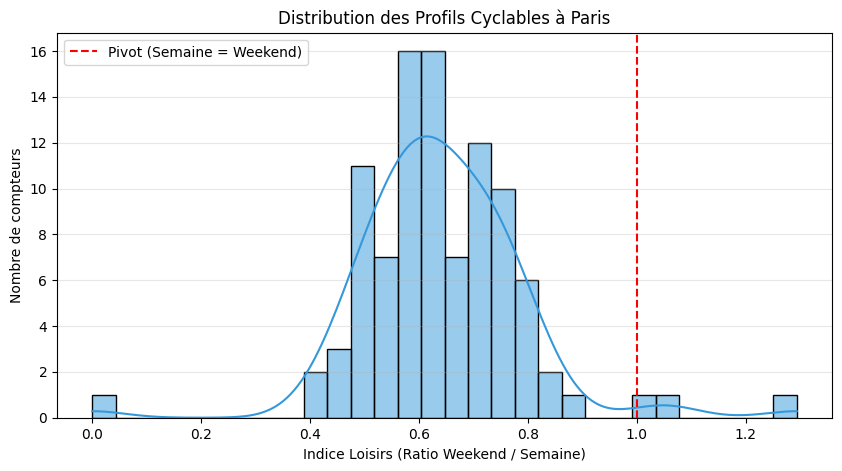

In [3]:
# 1. Agrégation des données : Moyenne par compteur selon si c'est le weekend ou non
analyse_profil = df_final.groupby(['compteur_nom', 'est_weekend'])['volume'].mean().unstack()

# Renommage des colonnes pour la clarté (False = Semaine, True = Weekend)
analyse_profil.columns = ['Moyenne_Semaine', 'Moyenne_Weekend']

# 2. Calcul de l'Indice de Loisirs
analyse_profil['Indice_Loisirs'] = analyse_profil['Moyenne_Weekend'] / analyse_profil['Moyenne_Semaine']

# 3. Affichage des extrêmes pour valider la logique
print("--- TOP 5 AXES LOISIRS (Promenade) ---")
display(analyse_profil.sort_values(by='Indice_Loisirs', ascending=False).head(5))

print("\n--- TOP 5 AXES VÉLOTAF (Domicile-Travail) ---")
display(analyse_profil.sort_values(by='Indice_Loisirs', ascending=True).head(5))

# 4. Visualisation de la distribution globale à Paris
plt.figure(figsize=(10, 5))
sns.histplot(analyse_profil['Indice_Loisirs'], bins=30, kde=True, color='#3498db')
plt.axvline(1, color='red', linestyle='--', label='Pivot (Semaine = Weekend)')
plt.title("Distribution des Profils Cyclables à Paris")
plt.xlabel("Indice Loisirs (Ratio Weekend / Semaine)")
plt.ylabel("Nombre de compteurs")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## 4. Segmentation Avancée : Clustering K-Means
Plutôt que de définir arbitrairement ce qui est "Vélotaf" ou "Loisirs", nous utilisons l'algorithme **K-Means**.
Cet algorithme va regrouper les compteurs en 3 familles homogènes basées sur leur comportement réel (leur Indice de Loisirs).

**Objectif :** Identifier scientifiquement les typologies de rues à Paris.

c:\Users\wael\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\wael\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\wael\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wael\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File

Centres des clusters identifiés : [np.float64(0.5493482433175363), np.float64(0.7371559376013379), np.float64(1.130527513154842)]


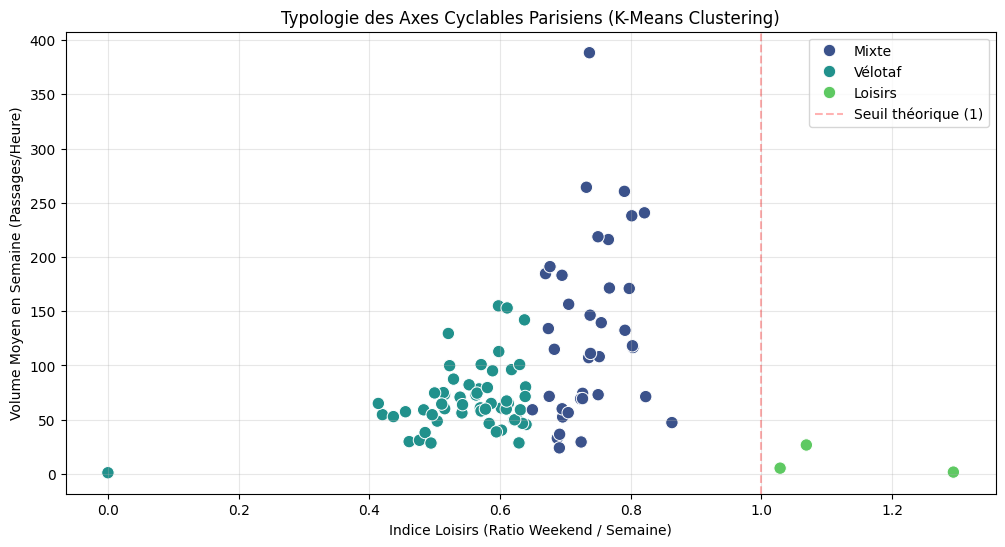


--- RÉPARTITION DES PROFILS IDENTIFIÉS ---
Typologie
Vélotaf    56
Mixte      38
Loisirs     3
Name: count, dtype: int64

--- LISTE DES COMPTEURS 'LOISIRS' (Exceptions) ---


,Moyenne_Semaine,Moyenne_Weekend,Indice_Loisirs,Typologie
compteur_nom,,,,
28 boulevard Diderot E-O,26.605040,28.438031,1.068896,Loisirs
Face au 8 avenue de la porte de Charenton NO-SE,5.235144,5.385704,1.028759,Loisirs
Face au 8 avenue de la porte de Charenton SE-NO,1.602292,2.073248,1.293927,Loisirs


In [4]:
from sklearn.cluster import KMeans

# 1. Préparation des données pour le modèle
# On nettoie les valeurs infinies ou nulles qui pourraient faire planter l'algorithme
df_clustering = analyse_profil.copy()
df_clustering.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean_cluster = df_clustering.dropna(subset=['Indice_Loisirs'])

# 2. Entraînement du modèle K-Means (3 clusters demandés)
X = df_clean_cluster[['Indice_Loisirs']].copy()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)

# 3. Analyse des centres de classes pour nommer les groupes
centres = sorted(kmeans.cluster_centers_.flatten())
print(f"Centres des clusters identifiés : {centres}")

# Fonction pour attribuer une étiquette intelligible selon la valeur du centre
def nommer_groupe(ratio):
    # On calcule la distance du ratio actuel vers chaque centre de cluster
    dist_1 = abs(ratio - centres[0]) # Le plus petit ratio (Vélotaf pur)
    dist_2 = abs(ratio - centres[1]) # Ratio moyen (Mixte)
    dist_3 = abs(ratio - centres[2]) # Le plus grand ratio (Loisirs)
    
    if dist_1 == min(dist_1, dist_2, dist_3):
        return "Vélotaf"
    elif dist_2 == min(dist_1, dist_2, dist_3):
        return "Mixte"
    else:
        return "Loisirs"

# Application des étiquettes
df_clean_cluster['Typologie'] = df_clean_cluster['Indice_Loisirs'].apply(nommer_groupe)

# 4. Visualisation des résultats du Clustering
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_clean_cluster, x='Indice_Loisirs', y='Moyenne_Semaine', hue='Typologie', palette='viridis', s=80)
plt.title("Typologie des Axes Cyclables Parisiens (K-Means Clustering)")
plt.xlabel("Indice Loisirs (Ratio Weekend / Semaine)")
plt.ylabel("Volume Moyen en Semaine (Passages/Heure)")
plt.axvline(1, color='red', linestyle='--', alpha=0.3, label='Seuil théorique (1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Bilan chiffré
print("\n--- RÉPARTITION DES PROFILS IDENTIFIÉS ---")
print(df_clean_cluster['Typologie'].value_counts())

print("\n--- LISTE DES COMPTEURS 'LOISIRS' (Exceptions) ---")
display(df_clean_cluster[df_clean_cluster['Typologie'] == 'Loisirs'])

## 5. Visualisation Géographique (Cartographie)
Nous allons projeter les résultats de notre clustering sur une carte de Paris pour analyser la distribution spatiale des comportements.

**Code couleur :**
*   <span style="color:#d63031">**Rouge (Vélotaf)**</span> : Axes purement utilitaires (domicile-travail).
*   <span style="color:#0984e3">**Bleu (Mixte)**</span> : Axes polyvalents (fort trafic semaine et weekend).
*   <span style="color:#00b894">**Vert (Loisirs)**</span> : Axes de promenade (plus fréquentés le weekend).

In [5]:
import folium
import pandas as pd

# --- PRÉPARATION DES DONNÉES GÉOGRAPHIQUES ---

# 1. Récupération des coordonnées uniques depuis le dataset original
coords = df_final[['compteur_nom', 'geo']].drop_duplicates()

# 2. Fusion avec les résultats du clustering
# reset_index() est nécessaire car 'compteur_nom' est l'index de df_clean_cluster
map_data = df_clean_cluster.reset_index().merge(coords, on='compteur_nom', how='left')

# 3. Séparation des coordonnées (Lat, Lon)
lat_lon = map_data['geo'].str.split(',', expand=True)
map_data['lat'] = lat_lon[0].astype(float)
map_data['lon'] = lat_lon[1].astype(float)

# --- CRÉATION DE LA CARTE ---

# 1. Initialisation de la carte centrée sur Paris
m = folium.Map(location=[48.8566, 2.3522], zoom_start=12, tiles='cartodbpositron')

# 2. Dictionnaire de couleurs
couleurs = {
    'Vélotaf': '#d63031',  # Rouge
    'Mixte':   '#0984e3',  # Bleu
    'Loisirs': '#00b894'   # Vert
}

# 3. Ajout des marqueurs
for index, row in map_data.iterrows():
    type_axe = row['Typologie']
    color = couleurs.get(type_axe, 'gray')
    
    # Contenu de la popup (HTML)
    popup_html = f"""
    <div style="font-family: Arial; width: 200px;">
        <h4>{row['compteur_nom']}</h4>
        <hr>
        <b>Type :</b> <span style="color:{color}; font-weight:bold;">{type_axe}</span><br>
        <b>Indice Loisirs :</b> {row['Indice_Loisirs']:.2f}<br>
        <br>
        <i>Moyenne Semaine : {row['Moyenne_Semaine']:.0f} vélos/h</i><br>
        <i>Moyenne Weekend : {row['Moyenne_Weekend']:.0f} vélos/h</i>
    </div>
    """
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"{row['compteur_nom']} ({type_axe})"
    ).add_to(m)

# 4. Ajout d'une légende flottante
legende_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 110px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity:0.9; padding: 10px;">
     <b>Légende</b><br>
     <i style="background:#d63031;width:10px;height:10px;display:inline-block;border-radius:50%;"></i> Vélotaf<br>
     <i style="background:#0984e3;width:10px;height:10px;display:inline-block;border-radius:50%;"></i> Mixte<br>
     <i style="background:#00b894;width:10px;height:10px;display:inline-block;border-radius:50%;"></i> Loisirs
     </div>
     '''
m.get_root().html.add_child(folium.Element(legende_html))

# Sauvegarde et Affichage
m.save("carte_typologie_velo_paris.html")
print("Carte générée et sauvegardée sous 'carte_typologie_velo_paris.html'")
m # Affiche la carte dans le notebook

Carte générée et sauvegardée sous 'carte_typologie_velo_paris.html'


## 6. Modélisation Prédictive : Random Forest
Nous allons construire un modèle de Machine Learning capable de prédire le nombre de vélos qui passeront à un endroit donné, à une heure donnée.

**Pourquoi Random Forest ?**
C'est un algorithme robuste qui gère bien les relations non-linéaires (ex: le trafic n'augmente pas linéairement avec l'heure, il fait des pics).

**Les variables explicatives (Features) :**
*   `heure` : L'heure de la journée (le facteur le plus important).
*   `mois` : La saisonnalité.
*   `jour_semaine` : Lundi vs Dimanche.
*   `est_weekend` : Jour ouvré ou repos.
*   `est_hiver` : Météo probable.
*   `compteur_nom_code` : L'emplacement géographique (encodé en chiffres).

Entraînement du modèle en cours... (cela peut prendre quelques secondes)

--- PERFORMANCE DU MODÈLE ---
R² Score (Précision globale) : 0.8685 (soit 86.9%)
Erreur Moyenne Absolue (MAE) : 19.3 vélos par heure


C:\Users\wael\AppData\Local\Temp\ipykernel_25296\2751117340.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable', data=importances, palette='viridis')


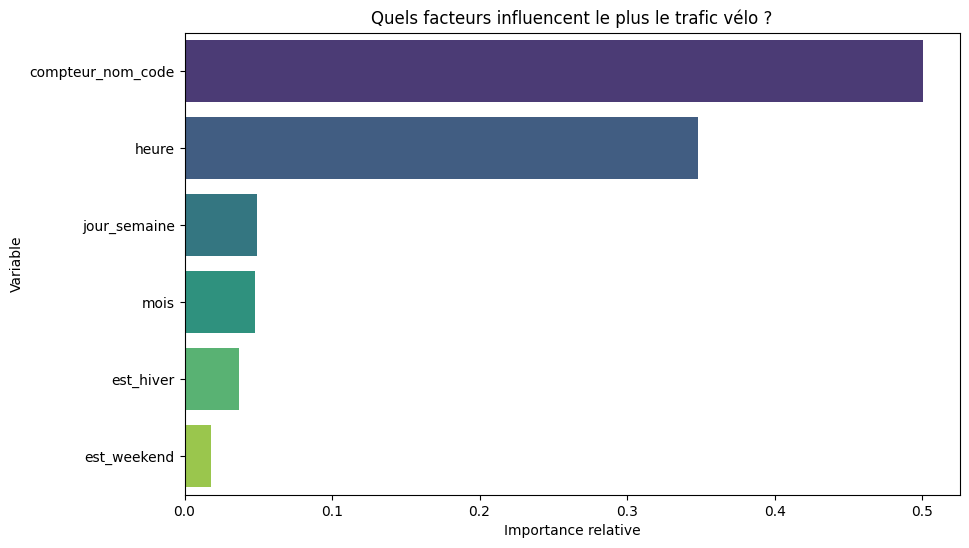

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 1. Préparation des données pour le modèle
# On encode le nom du compteur en chiffres pour que le modèle puisse l'utiliser
le = LabelEncoder()
df_final['compteur_nom_code'] = le.fit_transform(df_final['compteur_nom'])

# Définition des variables explicatives (X) et de la cible (y)
features = ['heure', 'mois', 'jour_semaine', 'est_weekend', 'est_hiver', 'compteur_nom_code']
X = df_final[features]
y = df_final['volume']

# Séparation en jeu d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Entraînement du modèle (Random Forest)
# n_estimators=50 : On utilise 50 arbres de décision
print("Entraînement du modèle en cours... (cela peut prendre quelques secondes)")
model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 3. Prédictions et Évaluation
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n--- PERFORMANCE DU MODÈLE ---")
print(f"R² Score (Précision globale) : {r2:.4f} (soit {r2*100:.1f}%)")
print(f"Erreur Moyenne Absolue (MAE) : {mae:.1f} vélos par heure")

# 4. Analyse de l'importance des variables
importances = pd.DataFrame({
    'Variable': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=importances, palette='viridis')
plt.title("Quels facteurs influencent le plus le trafic vélo ?")
plt.xlabel("Importance relative")
plt.show()

## 7. Conclusion Générale

### Analyse des Résultats du Modèle
Le modèle **Random Forest** obtient une performance remarquable avec un score **$R^2$ de 0.87**. Cela signifie que nous sommes capables d'expliquer **87% des variations du trafic cycliste** avec seulement quelques variables.

L'analyse de l'importance des variables (Feature Importance) nous livre une conclusion métier forte :
1.  **Le Lieu (`compteur_nom_code`) est déterminant (~50%)** : Le volume dépend avant tout de l'infrastructure (piste cyclable majeure vs petite rue).
2.  **L'Heure est le métronome (~35%)** : Le trafic suit un rythme pendulaire strict.
3.  **Les autres facteurs (Saison, Weekend) sont secondaires** : Bien qu'existants, ils ne modifient pas la structure fondamentale du trafic, qui reste utilitaire.

### Synthèse de l'Étude
À travers ce notebook, nous avons pu démontrer que :
*   **Paris est une ville de "Vélotaf"** : L'analyse par Clustering (K-Means) a révélé que la quasi-totalité des compteurs enregistrent plus de trafic en semaine que le week-end. Seuls 3 compteurs (sur près de 100) ont un profil "Loisirs".
*   **Le trafic est structurel et prévisible** : Loin d'être aléatoire, l'usage du vélo à Paris obéit à des règles strictes de géographie et d'horaires de bureau, ce qui permet une modélisation prédictive très fiable.